In [1]:
import os
from os import getcwd

import tensorflow as tf

In [2]:
# f0 = fibrosis false
# f1 = fibrosis true

try:
    os.mkdir('/tmp/Liver_tf')
    os.mkdir('/tmp/Liver_tf/training')
    os.mkdir('/tmp/Liver_tf/training/f0')
    os.mkdir('/tmp/Liver_tf/training/f1')
    os.mkdir('/tmp/Liver_tf/testing')
    os.mkdir('/tmp/Liver_tf/testing/f0')
    os.mkdir('/tmp/Liver_tf/testing/f1')
    
except OSError:
    pass

In [3]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)

In [4]:
F0_SOURCE_DIR = "../../../Data/Liver/fibrosis_false/"
TRAINING_F0_DIR = "/tmp/Liver_tf/training/f0/"
TESTING_F0_DIR = "/tmp/Liver_tf/testing/f0/"

F1_SOURCE_DIR = "../../../Data/Liver/fibrosis_true/"
TRAINING_F1_DIR = "/tmp/Liver_tf/training/f1/"
TESTING_F1_DIR = "/tmp/Liver_tf/testing/f1/"

split_size = .8

split_data(F0_SOURCE_DIR, TRAINING_F0_DIR, TESTING_F0_DIR, split_size)
split_data(F1_SOURCE_DIR, TRAINING_F1_DIR, TESTING_F1_DIR, 0.7)

In [5]:
print("Training Fibrosis 0:", len(os.listdir(TRAINING_F0_DIR)))
print("Testing Fibrosis 0:", len(os.listdir(TESTING_F0_DIR)))
print("-"*20)
print("Training Fibrosis 1:", len(os.listdir(TRAINING_F1_DIR)))
print("Testing Fibrosis 1:", len(os.listdir(TESTING_F1_DIR)))
print("-"*20)

Training Fibrosis 0: 1000
Testing Fibrosis 0: 223
--------------------
Training Fibrosis 1: 1774
Testing Fibrosis 1: 592
--------------------


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

TRAINING_DIR = '/tmp/Liver_tf/training'
train_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=64,
                                                   class_mode='binary',
                                                   target_size=(600,800),
                                                   color_mode='grayscale') # target_size = (height, width)

TESTING_DIR = '/tmp/Liver_tf/testing'
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_generator = train_datagen.flow_from_directory(TESTING_DIR,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(600,800), 
                                                   color_mode='grayscale')

Found 2774 images belonging to 2 classes.
Found 815 images belonging to 2 classes.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5,5), activation='relu', input_shape=(600,800,1)),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 596, 796, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 298, 398, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 294, 394, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 147, 197, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 463344)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               59308160  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=["acc"])

history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
44/44 [==============================] - 9s 214ms/step - loss: 2.1902 - acc: 0.6565 - val_loss: 0.5057 - val_acc: 0.7129
Epoch 2/30
44/44 [==============================] - 9s 204ms/step - loss: 0.5090 - acc: 0.7509 - val_loss: 0.4238 - val_acc: 0.8012
Epoch 3/30
44/44 [==============================] - 9s 207ms/step - loss: 0.4597 - acc: 0.7945 - val_loss: 0.3596 - val_acc: 0.8380
Epoch 4/30
44/44 [==============================] - 9s 205ms/step - loss: 0.3732 - acc: 0.8407 - val_loss: 0.2939 - val_acc: 0.8945
Epoch 5/30
44/44 [==============================] - 9s 206ms/step - loss: 0.2812 - acc: 0.8983 - val_loss: 0.2648 - val_acc: 0.8883
Epoch 6/30
44/44 [==============================] - 9s 205ms/step - loss: 0.1451 - acc: 0.9477 - val_loss: 0.2261 - val_acc: 0.9141
Epoch 7/30
44/44 [==============================] - 9s 205ms/step - loss: 0.0830 - acc: 0.9737 - val_loss: 0.2348 - val_acc: 0.9166


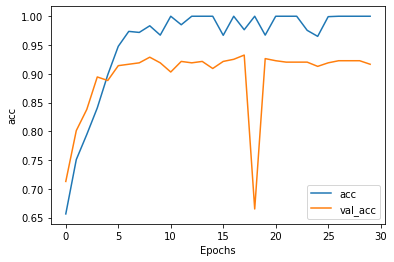

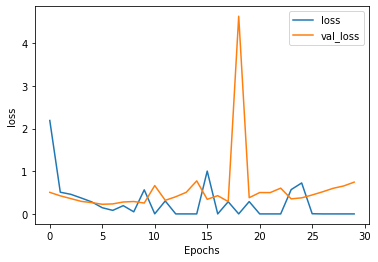

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
import os, signal

os.kill(os.getpid(),signal.SIGKILL)